In [2]:
# Importing libraries
import math
import numpy as np
from scipy.special import ndtri
from numpy.linalg import solve
from numpy.linalg import cholesky
from numpy.linalg import LinAlgError
from functools import partial
from scipy import integrate
from scipy.optimize import broyden1, broyden2, newton_krylov, fixed_point, fsolve, minimize, least_squares, minimize_scalar
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import seaborn as sns
from scipy.stats import multivariate_normal, norm 
import pickle
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
# Gaussian copula pdf
def _gaussian(x,y, kappa):
    R = cholesky([[1,kappa],[kappa,1]])
    x = ndtri([x,y])
    z = solve(R,x.T)
    log_det= np.sum(np.log(np.diag(R)))
    return np.exp(-0.5 * np.sum(  np.power(z,2) - np.power(x,2) ) - log_det)

In [3]:
# Calculate equilibrium sufficent statistic and varios helper functions

def acop(x,y,kappa):
    if normd == 0:
        return ( 1 + kappa * ((1+x)*(1+y)-3) + (kappa**2)*(1-x)*(1-y)) / ((1-kappa*(1-x)*(1-y))**3)
    elif normd == 1:
        return _gaussian(x,y, kappa)
    return 

def func_b(k,m):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: np.maximum(np.minimum(m + x * k,1),0), 1)
    return out -1/2

def det_m(k):
    return least_squares(partial(func_b,k),  [0.15],  bounds=[0.05,0.28]).x[0]

def func_mx(k,m):
    ans1, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda x: m + x * k,  1)
    ans0, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0,1 , 0, lambda x: m + x * k )
    return ans0/ans1

def func_x(k):
    k = np.minimum(1,k)
    m = det_m(k)
    ans1, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda x: m + x * k,  1)
    ans0, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0,1 , 0, lambda x: m + x * k )
    return ans0/ans1

In [4]:
normd = 0
kappa = 0.9
#newton_krylov(lambda k: func_x(k)-k,  [0])
least_squares(lambda k: func_x(k)-k,  [0.8], bounds=[0.5,1])


 active_mask: array([0])
        cost: 2.269693688858524e-06
         fun: array([0.00213058])
        grad: array([7.49415619e-08])
         jac: array([[3.5174191e-05]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 17
        njev: 12
  optimality: 2.893063245690075e-08
      status: 2
     success: True
           x: array([0.88604256])

In [4]:
# Calculate equilibrium sufficent statistic and varios helper functions
def limiter(a):
    return np.minimum(np.maximum(a,0),1)

def acop(x,y,kappa):
    if normd == 0:
        return ( 1 + kappa * ((1+x)*(1+y)-3) + (kappa**2)*(1-x)*(1-y)) / ((1-kappa*(1-x)*(1-y))**3)
    elif normd == 1:
        return _gaussian(x,y, kappa)
    return 

def beta_part(x):
    return 1-β*np.power(1-x,2)

def prod_function(θ,x):
    return θ * np.power(x,γ) + beta_part(x)

def theta_determiner(θ,x_0,x_1):
    return 1 if np.power(x_1,γ)==0 else ( prod_function(θ,x_0) - beta_part(x_1) ) / np.power(x_1,γ)

def func_determine_x(x_0,x_1):
    ans1, err1 = [0,0] if limiter(theta_determiner(0,x_0,x_1))==1 else integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda z: limiter(theta_determiner(z,x_0,x_1)),  1)
    ans0, err0 = [0,0] if limiter(theta_determiner(0,x_0,x_1))==0 else integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0, 1 , 0, lambda z: limiter(theta_determiner(z,x_0,x_1)))
    mul1, err2 = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0 , 1, lambda z: limiter(theta_determiner(z,x_0,x_1)),  1)
    mul0 = 1 - mul1
    out0 = 0 if mul0==0 else ans0 / mul0 
    out1 = 0 if mul1==0 else ans1 / mul1 
    return np.array([out0, out1])

def equilibrium_solve_mfirms(guess):
    return least_squares(lambda x: func_determine_x(x[0],x[1])-np.array([x[0],x[1]]),  guess, bounds=[[0,0],[1,1]])

In [6]:
normd = 1
kappa = 0
β =0.05
γ = 1
sol = equilibrium_solve_mfirms([1.9/3,2.1/3])
sol.x

array([7.41463098e-05, 5.00000000e-01])

In [7]:
x, y = sol.x
func_determine_x(x,y)

array([0. , 0.5])

In [8]:
sol.x

array([7.41463098e-05, 5.00000000e-01])

In [ ]:
# Plot describing equilibria for different values of the correlation parameter and AMH copula
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
d = np.arange(0, 1.01, 0.025)
fig, ax = plt.subplots( )

normd=0

vecfunc1 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc1(d), label='k')

a = 'x0(k)/x1(k),'.translate(subscript) + ' κappa = 0.99'
kappa=0.99
vecfunc2 = np.vectorize(func_x)
ax.plot(d,vecfunc2(d),label=a)

a = 'x0(k)/x1(k),'.translate(subscript) + ' κappa = 0.8'
kappa=0.8
vecfunc3 = np.vectorize(func_x)
ax.plot(d,vecfunc3(d),label=a)


a = 'x0(k)/x1(k),'.translate(subscript) + ' κappa = 0.4'
kappa=0.4
vecfunc4 = np.vectorize(func_x)
ax.plot(d,vecfunc4(d),label=a)

a = 'x0(k)/x1(k),'.translate(subscript) + ' κappa = 0'
kappa=0
vecfunc5 = np.vectorize(func_x)
ax.plot(d,vecfunc5(d),label=a)

a = 'x0(k)/x1(k),'.translate(subscript) + ' κappa = -0.4'
kappa=-0.4
vecfunc6 = np.vectorize(func_x)
ax.plot(d,vecfunc6(d),label=a)

ax.set_ylim([0.5, 1])
ax.set_xlim([0, 1])
ax.set_title("Illustration separate equilibrium - AMH copula")  
ax.set_xlabel('k')
ax.legend(loc='upper left')
plt.savefig('amh.png')

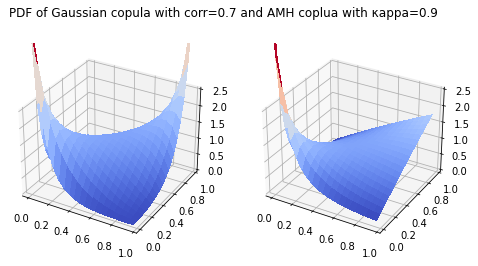

In [13]:
#3D plot of pdf of Gaussian and AMH copula
normd =1
kappa =0.7

fig = plt.figure(figsize=plt.figaspect(0.5))

#Create grid and multivariate normal
x = np.arange(0.01,0.99,0.05)
y = np.arange(0.01,0.99,0.05)
X, Y = np.meshgrid(x,y)

ax = fig.add_subplot(1, 2, 1, projection='3d')

zs = []
for i in np.arange(0.01,0.99,0.05):
    for j in np.arange(0.01,0.99,0.05):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)

#Make a 3D plot


ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.set_zlim([0, 2.5])



normd =0
kappa =0.9

ax = fig.add_subplot(1, 2, 2, projection='3d')

#Create grid and multivariate normal
zs = np.array(acop(np.ravel(X), np.ravel(Y), kappa))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


ax.set_zlim([0, 2.5])
plt.suptitle("PDF of Gaussian copula with corr=0.7 and AMH coplua with κappa=0.9") 

plt.savefig('pdf3d.png')


In [9]:
# Contour plot and equilibria distributions Gaussian and AMH copula

subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

fig = plt.figure(figsize=plt.figaspect(0.5))
d = np.arange(0, 1, 0.001)
vecfunc = np.vectorize(lambda x: (x-(1-k)/2)/k)
vecfunc2 = np.vectorize(lambda x: x)
x = np.arange(0.01,0.99,0.01)
y = np.arange(0.01,0.99,0.01)
X, Y = np.meshgrid(x,y)
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

normd = 1
kappa = 0.7
k=0.6
m=det_m(k)

ax = fig.add_subplot(1, 2, 1)

ax.plot(vecfunc(d),d,label='Separating equilibrium',linestyle='dashdot',color='black')
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_title("PDF Gaussian copula corr=0.7")  
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend()

zs = []
for i in np.arange(0.01,0.99,0.01):
    for j in np.arange(0.01,0.99,0.01):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=cm.coolwarm)



normd = 0
kappa = 0.9
k=newton_krylov(lambda k: func_x(k)-k,  [0.5])
m=det_m(k)

ax = fig.add_subplot(1, 2, 2)

ax.plot(vecfunc(d),d,label='Separating equilibrium',color='red')
vecfunc2 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_title("PDF AMH copula κappa=0.9")  
ax.set_xlabel('θ0'.translate(subscript))
ax.legend()
zs = np.array(acop(np.ravel(X), np.ravel(Y), kappa))
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=cm.coolwarm)
plt.contour(X,Y,Z)

plt.suptitle("Skill separation in competitive equilibria") 
plt.savefig('eqsep.png')

NameError: name 'ax' is not defined

<Figure size 576x288 with 0 Axes>

In [5]:
# A set of helper functions

def sol(kap):
    global kappa
    kappa = kap
    return newton_krylov(lambda k: func_x(k)-k,  [0.5])[0]

def sol_gamma(gamma):
    global γ
    γ = gamma
    out = np.power(newton_krylov(lambda k: func_x(k)-k,  [0.5])[0],γ)
    return out

def prod(x):
    return 10 + (beta/2)*x*np.power(x,γ)-((1-beta)/2)*np.power(1-x,2)

def cond_prod(θ,z):
    return beta*θ*np.power(z,γ)

def func_mx2(k,m):
    ans1, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda x: m + x * k,  1)
    ans0, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0,1 , 0, lambda x: m + x * k )
    return [2*ans0, 2*ans1]

def prod_tot_eq(kap):
    comp1 = lambda kap: func_mx2(sol(kap),det_m(sol(kap)))
    comp2 = lambda kap: comp1(kap)
    return prod(comp2(kap)[0]) + prod(comp2(kap)[1])

def prod_tot_ifc(kap):
    global kappa
    kappa = kap
    ans1, err1 = integrate.dblquad(lambda x,y: x*acop(x,y,kappa), 0 , 1, lambda x: x ,  1)
    ans0, err0 = integrate.dblquad(lambda x,y: y*acop(x,y,kappa), 0,1 , 0, lambda x:  x )
    return prod(2*ans1) + prod(2*ans0)

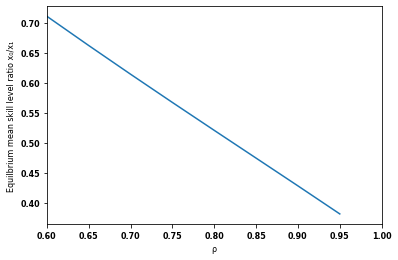

In [31]:
# Look at plot title
normd = 1
d = np.arange(0.6, 1, 0.05)
fig, ax = plt.subplots()
vecfunc = np.vectorize(sol)
ax.plot(d,vecfunc(d))
#ax.set_ylim([0.78, 1])
ax.set_xlim([0.6, 1])
#ax.set_title("Separating eq. as a function of κappa in the AMH copula")
ax.set_xlabel('ρ')
ax.set_ylabel('Equilbrium mean skill level ratio x0/x1'.translate(subscript))
plt.savefig('gceqcorr.png')

In [11]:
# Separating equilibrium as a function of degree of supermodularity
normd = 1
kappa = 0.8

d = np.arange(1, 6, 0.3)
vecfunc = np.vectorize(sol_gamma)

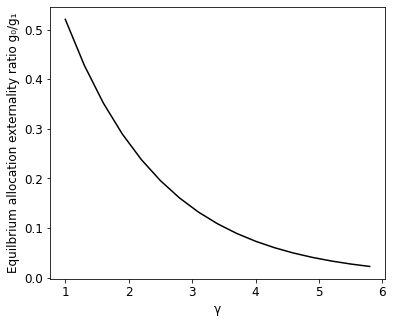

In [164]:
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
fig, ax = plt.subplots(figsize=(6, 5))
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.plot(d,vecfunc(d),color='black',label='Types distributed according to the Gaussian copula with ρ=0.8')
#ax.set_ylim([0.78, 1])
#ax.set_xlim([0.82, 1])
#ax.set_title("x0/x1 in separating equilibrium as a function of γ".translate(subscript))
ax.set_xlabel('γ')
ax.set_ylabel('Equilbrium allocation externality ratio g0/g1'.translate(subscript))
plt.savefig('gammacss.png')

In [ ]:
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
d = np.arange(0.82, 1, 0.05)
normd = 1
vecfunc = np.vectorize(prod_tot_eq)
fig, ax = plt.subplots(1,2)
#fig.suptitle("Total equilibrium productivity/efficency loss as a function of κappa")
fig.set_size_inches(8, 4)

ax[0].plot(d,vecfunc(d), label='Separating equilibrium')
vecfunc1 = np.vectorize(prod_tot_ifc)
ax[0].plot(d,vecfunc1(d), label = 'Efficient pooling equilibrium')
ax[0].set_xlim([0.82, 1])

ax[0].set_xlabel('ρ')
ax[0].set_ylabel('Total production'.translate(subscript))
ax[0].legend()

vecfunc2 = np.vectorize(lambda kap: prod_tot_ifc(kap) - prod_tot_eq(kap))
ax[1].plot(d,vecfunc2(d), label='Efficency loss absolute terms')
vecfunc3 = np.vectorize(lambda kap: (prod_tot_ifc(kap) - prod_tot_eq(kap))/prod_tot_ifc(kap))
ax[1].plot(d,vecfunc3(d), label = 'Efficency loss relative terms')
ax[1].set_xlabel('ρ')
ax[1].set_ylabel('Difference in total production'.translate(subscript))
ax[1].legend()
fig.tight_layout()
plt.savefig('eff2s.png')

In [6]:
def beta_part(x):
    return 1-β*np.power(1-x,2)

def theta_det(x_0,x_1,θ,C):
    if θ==0:
        return 0
    elif θ==1:
        return 1
    meany = C + np.power( x_0, γ ) * np.exp( ndtri( [θ] )[0] )
    meany = meany / np.power( x_1, γ )
    out = 0 if meany<= 0 else norm.cdf( np.log( meany ) )
    return out

def equilibrium_xs(x_0,x_1,C):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: theta_det(x_0,x_1,x,C), 1)
    out2, err2 = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: theta_det(x_1,x_0,x,-C), 1)
    ans0, err0 = integrate.dblquad(lambda y,x: x*acop(x,y,kappa), 0, 1, lambda x: 0, lambda x: theta_det(x_0,x_1,x,C))
    ans1, err1 = integrate.dblquad(lambda y,x: y*acop(x,y,kappa), 0, 1, lambda x: theta_det(x_0,x_1,x,C), 1)
    return np.array([2*ans0, 2*ans1, out-1/2,out2 -1/2])

def equilibrium_solve(beta, guess):
    global β
    β = beta
    return least_squares(lambda x: equilibrium_xs(x[0],x[1],x[2])-np.array([x[0],x[1],0,0]),  guess, bounds=[[0.1,0.1,0],[0.9,0.9, np.inf]])

def trans(θ,x):
    return norm.cdf( log_func(θ,x) )

def trans_diff(θ,x):
    return norm.pdf( log_func(θ,x) ) / ( θ - beta_part(x) )

def log_func(θ,x):
    out = ( θ - beta_part(x) ) / np.power( x, γ )
    checker = 0 if out <= 0 else np.log( out )
    return checker

def mass_wage_sector(x,θ,C,deff):
    if deff == 0:
        x_0, x_1 = x
        ans, err = integrate.quad(lambda x: acop(x,trans(θ,x_0),kappa), 0, theta_det(x_0,x_1,trans(θ,x_0),C))
    elif deff == 1:
        x_1, x_0 = x
        ans, err = integrate.quad(lambda x: acop(trans(θ,x_0),x,kappa), 0, theta_det(x_0,x_1,trans(θ,x_0),-C))
    out = ans * trans_diff(θ,x_0)
    return out

def summer(x,θ,C):
    x_0, x_1 = x
    ans0, err = integrate.quad(lambda x: acop(x,trans(θ,x_0),kappa), 0, theta_det(x_0,x_1,trans(θ,x_0),C))
    if θ >= C + beta_part(x_1):
        ans1, err = integrate.quad(lambda x: acop(trans(θ,x_1),x,kappa), 0, theta_det(x_1,x_0,trans(θ,x_1),-C))
        return ans0* trans_diff(θ,x_0) + ans1* trans_diff(θ,x_1)
    else:
        return ans0 * trans_diff(θ,x_0)

In [ ]:
# Solving for the separating equilibrium (good guess inserted)
β = 0
γ = 1
normd = 1
kappa = 0.50
eqk = equilibrium_solve(0,[0.4, 0.7, 0.1])
eqks = func_mx2(1,0)

In [8]:
0.43233884/0.6776,

(0.6380443329397875,)

In [23]:
eqk

 active_mask: array([0, 0, 0])
        cost: 4.890513134426298e-09
         fun: array([ 6.81769877e-05, -6.81535376e-05,  1.56215214e-05, -1.56201154e-05])
        grad: array([ 1.27673483e-09, -1.91664614e-09,  4.39517165e-05])
         jac: array([[-0.35123257, -0.64859539,  0.53864016],
       [-0.64872378, -0.35145125, -0.53870264],
       [-0.64867207,  0.64864329, -0.94379079],
       [ 0.64867133, -0.64864579,  0.94379519]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 10
        njev: 10
  optimality: 9.781831752341899e-09
      status: 1
     success: True
           x: array([6.14852759e-01, 6.15200662e-01, 2.22558583e-04])

In [25]:
# Testing that this is in fact probability distributions
x_1, x_0, C = eqk.x
β = 1
if x_0 > x_1:
    C = -C
    x_low = - C + beta_part(x_0)
else:
    x_low = beta_part(x_0)
    
integrate.dblquad(lambda x, y: trans_diff(y,x_0)*acop(trans(y,x_0),x,kappa), x_low, 18, lambda y: 0, lambda y: theta_det(x_0,x_1,trans(y,x_0),C))

(0.49914677021141796, 1.4120071231042705e-08)

In [13]:
#Plotting wage distributions
normd = 1
x_0, x_1, C = eqk.x
x = eqk.x[0:2]
x_sym =eqks[0]
for beeta in [0,1]:
    β=beeta
    
    d_low = np.arange(beta_part(x_0)+0.01, 3, 0.01)
    d_high = np.arange(C + beta_part(x_1)+0.01, 3, 0.01)
    d_med = np.arange(beta_part(x_sym)+0.01, 3, 0.01)
    


    low_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,0))(d_low)
    high_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,1))(d_high)
    med_wage = np.vectorize(lambda θ: mass_wage_sector(eqks,θ,0,0))(d_med)

    fig, ax = plt.subplots()

    ax.plot(d_high,high_wage, label='Separating eq. high sector', color='black', linestyle='dotted')
    ax.plot(d_low,low_wage, label='Separating eq. low sector', color='black', linestyle='dashed')
    ax.plot(d_med,med_wage, label='Symmetric eq. single sector', color='black')

    plt.legend()
    #plt.title('Wage distributions in different eq')
    plt.xlabel('Wage')
    plt.ylabel('Density')
    plt.savefig('wage_dist_rho90_beta' + f'{str(beeta)}' +'.png')    
     

β=0

d_low = np.arange(beta_part(x_0)+0.01, 3, 0.01)
d_med = np.arange(beta_part(x_sym)+0.01, 3, 0.01)
sum_wage = np.vectorize(lambda θ: summer(x,θ,C))(d_low)
med_wage = np.vectorize(lambda θ: mass_wage_sector(eqks,θ,0,0))(d_med)
sum_med_wage = 2*med_wage

fig, ax = plt.subplots()

ax.plot(d_low,sum_wage, label='Separting eq., β=0',color='black', linestyle='dashed')
ax.plot(d_med,sum_med_wage, label='Symmetric eq.',color='black')


β=1
adj = 1-beta_part(x_sym)
d_low_2 = np.arange(beta_part(x_0)+0.01, 3, 0.01)
sum_wage_2 = np.vectorize(lambda θ: summer(x,θ,C))(d_low_2)

d = d_low_2 + adj

ax.plot(d[:-int(adj*100)],sum_wage_2[:-int(adj*100)], label='Separting eq. (adjusted), β=1',color='black', linestyle='dotted')
plt.legend()
plt.xlabel('Wage')
plt.ylabel('Density')

axins = zoomed_inset_axes(ax, 10, loc=7)
axins.plot(d_low,sum_wage,color='black', linestyle='dashed')
axins.plot(d_med,sum_med_wage, color='black')
axins.plot(d,sum_wage_2, linestyle='dotted',color='black')


# sub region of the original image
x1, x2, y1, y2 = 2.86, 2.95, 0.1098, 0.152
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
#plt.title('Total wage distributions in different eq')

plt.savefig('tot_wage_dist2.png')

NameError: name 'eqk' is not defined

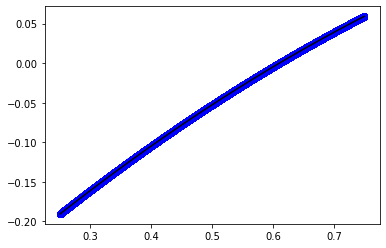

0.5


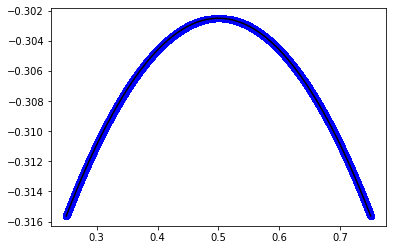

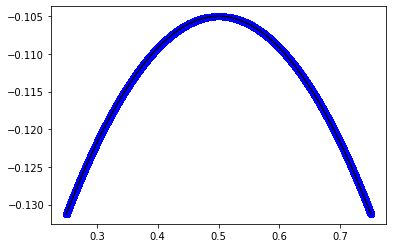

In [4]:
# Equilibrium inexistance calculations
b=0.29
def f(d):
    return (b/2)*d**2-(1-b)/2*(1-d)**2
vecfunc = np.vectorize(f)

d = np.arange(1/4, 3/4, 0.00001)
T = vecfunc(d)
plt.plot (d, T, 'bo', d, T, 'k')
plt.show()

solution = minimize_scalar(lambda d: -(f(d)+f(1-d)), bounds=[1/4,3/4], method='bounded')
print(solution.x)
def g(x,y,z):
    if y < 1/2:
        return z*x
    elif x < 1/2 and y > 1/2:
        return (y*(1-z)+(1-y)*z)*x 
    else:
        return (y*z+(1-y)*(1-z))*x-(1-2*y)*(1-2*z)/2

def h(d):
    return g(d,b,solution.x)

vecfunc2 = np.vectorize(h)
TT =vecfunc(d)-vecfunc2(d)
plt.plot (d, TT, 'bo', d, TT, 'k')
plt.show()


TTT = vecfunc(d)+vecfunc(1-d)
plt.plot (d, TTT, 'bo', d, TTT, 'k')
plt.show()

def i(x0,x1,y0,y1):
        return 5*(y0+y1)+b*(x0*y0+x1*y1)*(x0+x1)*(y0+y1)--(3-2*b)/2*x0*y0-(1+2*b)/2*x1*y1+(2*b-1)/2*y1
    

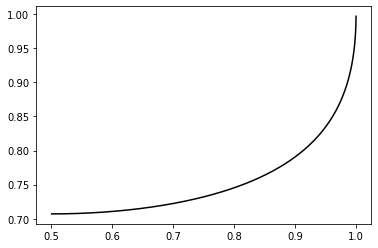

In [8]:
def ll(x):
    return -(math.sqrt(x)-math.sqrt(1-x))/(1-2*x)
d = np.arange(0.501, 1, 0.00001)
vecfunc2 = np.vectorize(ll)
T = vecfunc2(d)
plt.plot (d, T, 'k')
plt.show()

In [ ]:
# More equilibrium inexistance calculations
b=0.27
def f(d):
    return (b/2)*d**2+(1-b)/2*math.sqrt(d)
vecfunc = np.vectorize(f)

d = np.arange(1/4, 3/4, 0.00001)
T = vecfunc(d)
plt.plot (d, T)
plt.show()
plt.clf()

solution = minimize_scalar(lambda d: -(f(d)+f(1-d)), bounds=[1/4,3/4], method='bounded')
print(solution)
def g(x):
    return b*x+(1-b)/(4*math.sqrt(x))
print(g(solution.x))
print(g(1-solution.x))
print(f(solution.x)-g(solution.x)*solution.x/2)
print(f(1-solution.x)-g(solution.x)*(1-solution.x)/2)
d = np.arange(1/4, 3/4, 0.00001)
TT = vecfunc(d)-g(solution.x)*d/2
plt.plot (d, TT)
plt.show()
plt.clf()

d = np.arange(5/16, 11/16, 0.00001)
T = vecfunc(d)/2+vecfunc(1-d)/2
plt.plot (d, T, label='F_0(x)+F_1(1-x)')
plt.axvline(x=0.455)
plt.axvline(x=0.545)
plt.xlabel('mean skill level x for sector 0 and 1-x for sector 1')
plt.ylabel('Social surplus')
plt.title('    The social surplus function ')
plt.legend()
plt.show()
plt.clf()

def i(d):
    return g(d)-g(1-d)
vecfunc = np.vectorize(i)

TTT = vecfunc(d)
plt.plot (d, TTT)
plt.show()
plt.clf()

def j(d):
    return b-(1-b)/(8*d**1.5)
vecfunc = np.vectorize(j)

d = np.arange(1/4, 3/4, 0.00001)
T = vecfunc(d)
plt.plot (d, T)
plt.show()
plt.clf()
def fer(a):
    return -(1-2*a)*g(1-a)*2+b*(1-a)**2+(1-b)*math.sqrt(1-a)-b*a**2-(1-b)*math.sqrt(a)
def ferr(a):
    return (1-2*a)*g(a)*2-b*(1-a)**2-(1-b)*math.sqrt(1-a)+b*a**2+(1-b)*math.sqrt(a)
d = np.arange(1/4, 3/4, 0.00001)
vecfunc = np.vectorize(fer)
T = vecfunc(d)
vecfunc = np.vectorize(ferr)
TT = vecfunc(d)
plt.plot (d, T)
plt.plot (d, TT)
plt.show()
plt.clf()

x_1=0.3


def f2(x):
    return ((b/2)*(x**2-(1-x)**2)+((1-b)/2)*(math.sqrt(x)-math.sqrt((1-x))))/(2*x-1)


solution2 = minimize_scalar(lambda d: (g(d)-f2(d))**2, bounds=[1/4,5/11], method='bounded')


d = np.arange(1/4, 3/4, 0.00001)
vecfunc = np.vectorize(g)
T = vecfunc(d)
vecfunc = np.vectorize(f2)
TT = vecfunc(d)
plt.plot (d, T)
plt.plot (d, TT)
plt.show()
plt.clf()


def f3(x):
    return -x**2/2+2*x+5
def f4(x):
    return x**2+x/2+5+9/32
def f5(x):
    return 5.09+1.6*x
def f6(x):
    return 5+1.6*x



d = np.arange(1/4, 3/4, 0.00001)
vecfunc = np.vectorize(f3)
T = vecfunc(d)
vecfunc = np.vectorize(f4)
TT = vecfunc(d)
vecfunc = np.vectorize(f5)
TTT = vecfunc(d)
vecfunc = np.vectorize(f6)
TTTT = vecfunc(d)
plt.plot (d, T, label='5-(x^2)/2+2x')
plt.plot (d, TT, label='5+x^2+x/2+9/32')
plt.plot(d,TTT)
plt.plot(d,TTTT)
plt.xlabel('x')
plt.ylabel('F_i(x)')
plt.title('The surplus functions as function of the mean skill level')
plt.legend()
plt.show()
plt.clf()

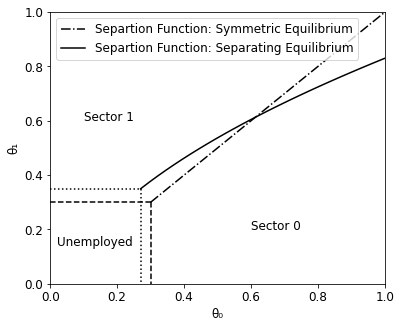

In [45]:
# Plot describing equilibria for different values of the correlation parameter and AMH copula
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
d = np.arange(0.3, 1.05, 0.025)
dd = np.arange(0.27, 1.05, 0.025)
fig, ax = plt.subplots(figsize=(6, 5))


for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

    
vecfunc1 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc1(d), label='Separtion Function: Symmetric Equilibrium',linestyle='dashdot',color='black')

vecfunc2 = np.vectorize(lambda x: x**(0.5)-0.17)
ax.plot(dd,vecfunc2(dd), label='Separtion Function: Separating Equilibrium',color='black')
plt.plot([0, 0.3], [0.3, 0.3], 'k--')
plt.plot([0.3, 0.3], [0.3, 0], 'k--')
plt.plot([0, 0.27], [(0.3**(0.5)-0.2), (0.3**(0.5)-0.2)],color='black', linestyle='dotted')
plt.plot([0.27, 0.27], [(0.3**(0.5)-0.2), 0],color='black', linestyle='dotted')
plt.text(0.02, 0.14, 'Unemployed', fontsize=12)
plt.text(0.1, 0.6, 'Sector 1', fontsize=12)
plt.text(0.6, 0.2, 'Sector 0', fontsize=12)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.savefig('isf.png')

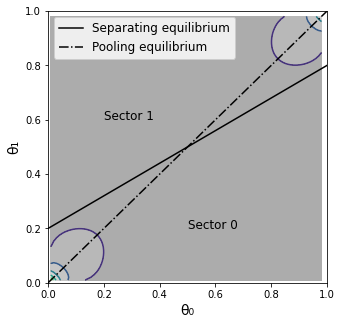

In [50]:
#3D plot of pdf of Gaussian and AMH copula
normd = 1
kappa = 0.7
k=0.6
m=det_m(k)


# Contour plot and equilibria distributions Gaussian and AMH copula

fig, ax = plt.subplots(figsize=(5, 5))
d = np.arange(0, 1, 0.001)
vecfunc = np.vectorize(lambda x: (x-(1-k)/2)/k)
vecfunc2 = np.vectorize(lambda x: x)
x = np.arange(0.01,0.99,0.01)
y = np.arange(0.01,0.99,0.01)
X, Y = np.meshgrid(x,y)


zs = []
for i in np.arange(0.01,0.99,0.01):
    for j in np.arange(0.01,0.99,0.01):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=plt.cm.gray,alpha=0.35)



ax.plot(vecfunc(d),d,label='Separating equilibrium',color='black')
vecfunc2 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',linestyle='dashdot',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.text(0.2, 0.6, 'Sector 1', fontsize=12)
plt.text(0.5, 0.2, 'Sector 0', fontsize=12)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    
plt.contour(X,Y,Z)

#plt.suptitle("Skill separation in competitive equilibria") 
plt.savefig('eqsepss.png')

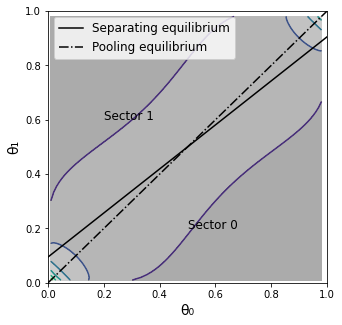

In [49]:
#3D plot of pdf of Gaussian and AMH copula
normd = 1
kappa = 0.5
k=0.81
m=det_m(k)



# Contour plot and equilibria distributions Gaussian and AMH copula

fig, ax = plt.subplots(figsize=(5, 5))
d = np.arange(0, 1, 0.001)
vecfunc = np.vectorize(lambda x: (x-(1-k)/2)/k)
vecfunc2 = np.vectorize(lambda x: x)
x = np.arange(0.01,0.99,0.01)
y = np.arange(0.01,0.99,0.01)
X, Y = np.meshgrid(x,y)


zs = []
for i in np.arange(0.01,0.99,0.01):
    for j in np.arange(0.01,0.99,0.01):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)
ax.contourf(X, Y, Z, cmap=plt.cm.gray,alpha=0.35)



ax.plot(vecfunc(d),d,label='Separating equilibrium',color='black')
vecfunc2 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc2(d), label='Pooling equilibrium',linestyle='dashdot',color='black')
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('θ0'.translate(subscript))
ax.set_ylabel('θ1'.translate(subscript))
ax.legend(loc='upper left',prop={'size': 12})
plt.text(0.2, 0.6, 'Sector 1', fontsize=12)
plt.text(0.5, 0.2, 'Sector 0', fontsize=12)
for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    
plt.contour(X,Y,Z)

#plt.suptitle("Skill separation in competitive equilibria") 
plt.savefig('eqsepss05.png')

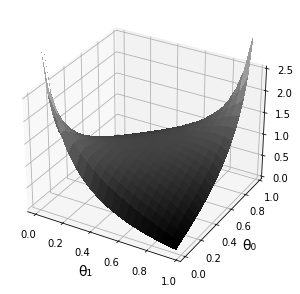

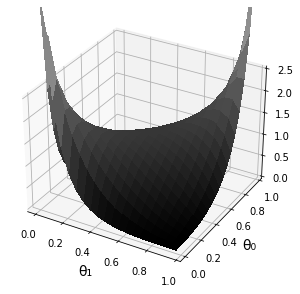

In [48]:

normd = 1
kappa = 0.5
k=0.81
m=det_m(k)

fig = plt.figure(figsize=(5, 5))


plt.gcf().set_size_inches(5, 5)

#Create grid and multivariate normal
x = np.arange(0.01,0.99,0.05)
y = np.arange(0.01,0.99,0.05)
X, Y = np.meshgrid(x,y)

ax = fig.add_subplot(1, 1, 1, projection='3d')

zs = []
for i in np.arange(0.01,0.99,0.05):
    for j in np.arange(0.01,0.99,0.05):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)

#Make a 3D plot

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.gray,
                       linewidth=0, antialiased=False)
ax.set_xlabel('θ1'.translate(subscript))
ax.set_ylabel('θ0'.translate(subscript))

for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    

ax.set_zlim([0, 2.5])


ax.set_zlim([0, 2.5])
#plt.suptitle("PDF of Gaussian copula with corr=0.7 and AMH coplua with κappa=0.9") 

plt.savefig('pdf3dss05.png')


normd = 1
kappa = 0.7
k=0.6
m=det_m(k)

fig = plt.figure(figsize=(5, 5))


plt.gcf().set_size_inches(5, 5)

#Create grid and multivariate normal
x = np.arange(0.01,0.99,0.05)
y = np.arange(0.01,0.99,0.05)
X, Y = np.meshgrid(x,y)

ax = fig.add_subplot(1, 1, 1, projection='3d')

zs = []
for i in np.arange(0.01,0.99,0.05):
    for j in np.arange(0.01,0.99,0.05):
        zs.append(acop(i,j,kappa))
zs = np.array(zs)
Z = zs.reshape(X.shape)

#Make a 3D plot

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.gray,
                       linewidth=0, antialiased=False)
ax.set_xlabel('θ1'.translate(subscript))
ax.set_ylabel('θ0'.translate(subscript))

for item in ([ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(14)    

ax.set_zlim([0, 2.5])


ax.set_zlim([0, 2.5])
#plt.suptitle("PDF of Gaussian copula with corr=0.7 and AMH coplua with κappa=0.9") 

plt.savefig('pdf3dss.png')


arg0


/home/peter/miniconda3/envs/tutorial/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


arg1
arg2


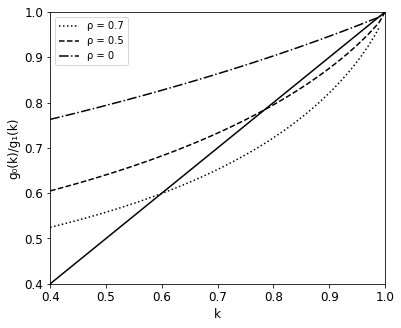

In [34]:
# Plot describing equilibria for different values of the correlation parameter and gaussian copula
# Calculate equilibrium sufficent statistic and varios helper functions

def acop(x,y,kappa):
    if normd == 0:
        return ( 1 + kappa * ((1+x)*(1+y)-3) + (kappa**2)*(1-x)*(1-y)) / ((1-kappa*(1-x)*(1-y))**3)
    elif normd == 1:
        return _gaussian(x,y, kappa)
    return 

def func_b(k,m):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,0.998, lambda x: np.maximum(np.minimum(m + x * k,1),0), 0.998)
    return out - 1/2

def det_m(k):
    return least_squares(partial(func_b,k),  [0.05],  bounds=[0,0.5]).x[0]



subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
d = np.arange(0.4, 1.01, 0.01)
fig, ax = plt.subplots(figsize=(6, 5))

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
normd=1

vecfunc1 = np.vectorize(lambda x: x)
ax.plot(d,vecfunc1(d),color='black')
print('arg0')
a = 'ρ = 0.7'
kappa=0.7
vecfunc2 = np.vectorize(func_x)
ax.plot(d,vecfunc2(d),label=a,color='black', linestyle='dotted')
print('arg1')
a =  'ρ = 0.5'
kappa=0.5
vecfunc3 = np.vectorize(func_x)
ax.plot(d,vecfunc3(d),label=a,color='black', linestyle='dashed')
print('arg2')
a = 'ρ = 0'
kappa=0
vecfunc5 = np.vectorize(func_x)
ax.plot(d,vecfunc5(d),label=a,color='black', linestyle='dashdot')


ax.set_ylim([0.4, 1])
ax.set_xlim([0.4, 1])
#ax.set_title("Illustration separate equilibrium - Gaussian copula")  
ax.set_xlabel('k')
ax.set_ylabel('g0(k)/g1(k)'.translate(subscript))
ax.legend()
plt.savefig('gc.png')

In [36]:
normd = 1
kappa = 0.7
#newton_krylov(lambda k: func_x(k)-k,  [0])
xx = least_squares(lambda k: func_x(k)-k,  [0.59], bounds=[0.5,0.82])
xx

 active_mask: array([0])
        cost: 1.9524333798745084e-16
         fun: array([-1.97607357e-08])
        grad: array([1.01205059e-08])
         jac: array([[-0.51215228]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 1.157373465752371e-09
      status: 1
     success: True
           x: array([0.61435925])

In [25]:
k=0.81164577
m=det_m(k)

In [31]:
kappa=0.7
func_mx(k,m)

0.8116457959806701

In [40]:
kappa=0
func_mx2(1,0)

[0.6666666666666667, 0.6666666666666666]

In [32]:
print(1/0.8116457959806701, 1/0.7407431743146999)

1.2320645347417234 1.3499955648260304


In [17]:
ω = 4
def beta_part(x):
    return 1-β*np.power(1-x,2)

def theta_det(x_0,x_1,θ,C):
    if θ==0:
        return 0
    elif θ==1:
        return 1
    meany = C + np.power( x_0, γ ) * np.exp( ω * ndtri( [θ] )[0] )
    meany = meany / np.power( x_1, γ )
    out = 0 if meany<= 0 else norm.cdf( np.log( meany ) / ω )
    return out

def equilibrium_xs(x_0,x_1,C):
    out, err = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: theta_det(x_0,x_1,x,C), 1)
    out2, err2 = integrate.dblquad(lambda x,y: acop(x,y,kappa), 0,1, lambda x: theta_det(x_1,x_0,x,-C), 1)
    ans0, err0 = integrate.dblquad(lambda y,x: x*acop(x,y,kappa), 0, 1, lambda x: 0, lambda x: theta_det(x_0,x_1,x,C))
    ans1, err1 = integrate.dblquad(lambda y,x: y*acop(x,y,kappa), 0, 1, lambda x: theta_det(x_0,x_1,x,C), 1)
    return np.array([ans0+1-ans1, ans1-ans0, out-1/2,out2 -1/2])

def equilibrium_solve(beta, guess):
    global β
    β = beta
    return least_squares(lambda x: equilibrium_xs(x[0],x[1],x[2])-np.array([x[0],x[1],0,0]),  guess, bounds=[[0.1,0.1,0],[0.9,0.9, np.inf]])

def trans(θ,x):
    return norm.cdf( log_func(θ,x) )

def trans_diff(θ,x):
    return norm.pdf( log_func(θ,x) ) / ( θ - beta_part(x) )

def log_func(θ,x):
    out = ( θ - beta_part(x) ) / np.power( x, γ )
    checker = 0 if out <= 0 else np.log( out )
    return checker

def mass_wage_sector(x,θ,C,deff):
    if deff == 0:
        x_0, x_1 = x
        ans, err = integrate.quad(lambda x: acop(x,trans(θ,x_0),kappa), 0, theta_det(x_0,x_1,trans(θ,x_0),C))
    elif deff == 1:
        x_1, x_0 = x
        ans, err = integrate.quad(lambda x: acop(trans(θ,x_0),x,kappa), 0, theta_det(x_0,x_1,trans(θ,x_0),-C))
    out = ans * trans_diff(θ,x_0)
    return out

def summer(x,θ,C):
    x_0, x_1 = x
    ans0, err = integrate.quad(lambda x: acop(x,trans(θ,x_0),kappa), 0, theta_det(x_0,x_1,trans(θ,x_0),C))
    if θ >= C + beta_part(x_1):
        ans1, err = integrate.quad(lambda x: acop(trans(θ,x_1),x,kappa), 0, theta_det(x_1,x_0,trans(θ,x_1),-C))
        return ans0* trans_diff(θ,x_0) + ans1* trans_diff(θ,x_1)
    else:
        return ans0 * trans_diff(θ,x_0)

In [18]:
# Solving for the separating equilibrium (good guess inserted)
β = 0
γ = 1
normd = 1
kappa = 0.9
eqk = equilibrium_solve(0,[0.9, 0.1, 0.9])
eqks = func_mx2(1,0)

In [16]:
eqk

 active_mask: array([1, 1, 0])
        cost: 0.010000001546624532
         fun: array([ 1.00000363e-01,  9.99996373e-02, -3.93348383e-05,  3.93161093e-05])
        grad: array([-0.09998069, -0.10001931,  0.02393989])
         jac: array([[-7.52198979e-01, -2.47788861e-01,  3.21926688e+00],
       [-2.47800998e-01, -7.52211124e-01, -3.21926689e+00],
       [-2.47771513e-01,  2.47811198e-01, -3.04277733e+02],
       [ 2.47772679e-01, -2.47810706e-01,  3.04425806e+02]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 17
        njev: 17
  optimality: 2.696888929636808e-09
      status: 1
     success: True
           x: array([9.00000000e-01, 9.00000000e-01, 1.12652533e-07])

In [14]:
# Testing that this is in fact probability distributions
x_1, x_0, C = eqk.x
β = 1
if x_0 > x_1:
    C = -C
    x_low = - C + beta_part(x_0)
else:
    x_low = beta_part(x_0)
    
integrate.dblquad(lambda x, y: trans_diff(y,x_0)*acop(trans(y,x_0),x,kappa), x_low, 18, lambda y: 0, lambda y: theta_det(x_0,x_1,trans(y,x_0),C))

(0.4984606189514789, 1.4705834187542233e-08)

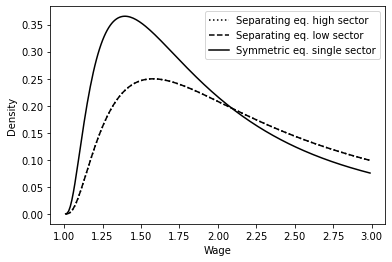

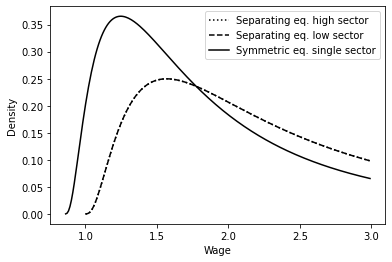

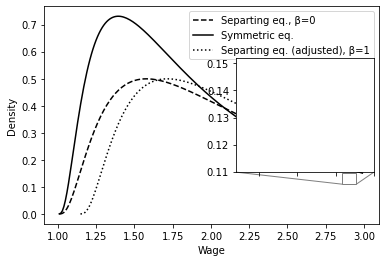

In [15]:
#Plotting wage distributions
normd = 1
x_0, x_1, C = eqk.x
x = eqk.x[0:2]
x_sym =eqks[0]
for beeta in [0,1]:
    β=beeta
    
    d_low = np.arange(beta_part(x_0)+0.01, 3, 0.01)
    d_high = np.arange(C + beta_part(x_1)+0.01, 3, 0.01)
    d_med = np.arange(beta_part(x_sym)+0.01, 3, 0.01)
    


    low_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,0))(d_low)
    high_wage = np.vectorize(lambda θ: mass_wage_sector(x,θ,C,1))(d_high)
    med_wage = np.vectorize(lambda θ: mass_wage_sector(eqks,θ,0,0))(d_med)

    fig, ax = plt.subplots()

    ax.plot(d_high,high_wage, label='Separating eq. high sector', color='black', linestyle='dotted')
    ax.plot(d_low,low_wage, label='Separating eq. low sector', color='black', linestyle='dashed')
    ax.plot(d_med,med_wage, label='Symmetric eq. single sector', color='black')

    plt.legend()
    #plt.title('Wage distributions in different eq')
    plt.xlabel('Wage')
    plt.ylabel('Density')
    plt.savefig('wage_dist_rho90_beta' + f'{str(beeta)}' +'cb.png')    
     

β=0

d_low = np.arange(beta_part(x_0)+0.01, 3, 0.01)
d_med = np.arange(beta_part(x_sym)+0.01, 3, 0.01)
sum_wage = np.vectorize(lambda θ: summer(x,θ,C))(d_low)
med_wage = np.vectorize(lambda θ: mass_wage_sector(eqks,θ,0,0))(d_med)
sum_med_wage = 2*med_wage

fig, ax = plt.subplots()

ax.plot(d_low,sum_wage, label='Separting eq., β=0',color='black', linestyle='dashed')
ax.plot(d_med,sum_med_wage, label='Symmetric eq.',color='black')


β=1
adj = 1-beta_part(x_sym)
d_low_2 = np.arange(beta_part(x_0)+0.01, 3, 0.01)
sum_wage_2 = np.vectorize(lambda θ: summer(x,θ,C))(d_low_2)

d = d_low_2 + adj

ax.plot(d[:-int(adj*100)],sum_wage_2[:-int(adj*100)], label='Separting eq. (adjusted), β=1',color='black', linestyle='dotted')
plt.legend()
plt.xlabel('Wage')
plt.ylabel('Density')

axins = zoomed_inset_axes(ax, 10, loc=7)
axins.plot(d_low,sum_wage,color='black', linestyle='dashed')
axins.plot(d_med,sum_med_wage, color='black')
axins.plot(d,sum_wage_2, linestyle='dotted',color='black')


# sub region of the original image
x1, x2, y1, y2 = 2.86, 2.95, 0.1098, 0.152
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
#plt.title('Total wage distributions in different eq')

plt.savefig('tot_wage_dist2cb.png')